In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import radTrans as rt
from scipy.interpolate import interp1d
import importlib
importlib.reload(rt)
import pandas as pd

sig [mm] =  -17.918080880347354


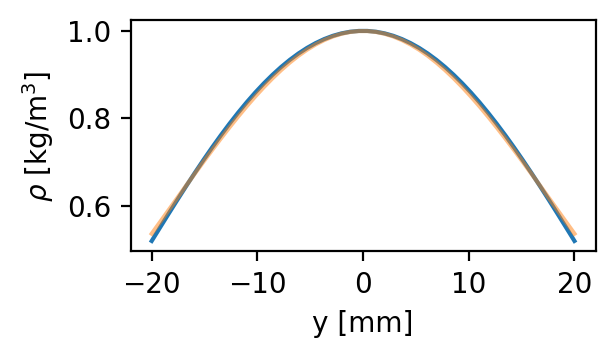

In [2]:
# Aside: determining sigma using rocket model
from scipy.optimize import curve_fit

def I(t,t_rise):
    return 1e6 * np.sin(2 * np.pi * t / (4 * t_rise))**2

def gaussian(x,sig):
    return np.exp(-(x-0)**2 / (2 * sig**2))


def getDenisty(x,y,t,V,R0,t_rise):
    mu0 = 1.2566e-06
    r = np.sqrt(x**2 + y**2)
    return mu0 / (8 * np.pi**2 * R0 * r * V**2) * (I(t-(r-R0)/V,t_rise))**2
    
R0 = 20e-3 # m
V = 110e3 # m/s
x = 20e-3 + R0 # m
y = np.linspace(-20e-3,20e-3,50)
t_rise = 300e-9 # s
t = 400e-9 # s

rho = getDenisty(x,y,t,V,R0,t_rise)
rho = rho / np.max(rho) # normalize


# fit a gaussain to rho
popt, pcov = curve_fit(gaussian, y, rho)


fig, axs = plt.subplots(1,1,figsize=(3,1.5),dpi=200)


axs.plot(y*1e3,rho)
axs.plot(y*1e3,gaussian(y, *popt),label='Fit',color='tab:orange',alpha=0.5)
axs.set_xlabel('y [mm]')
axs.set_ylabel('$\\rho$ [kg/m$^3$]')

print('sig [mm] = ', popt[0]*1e3)


m, c =  69671.23845959302 -0.009625876513625944


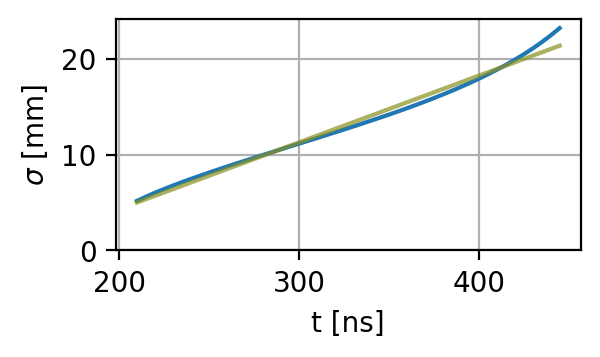

In [3]:
# do it for multiple times

# experiment properties
R0 = 20e-3 # m
V = 110e3 # m/s
x = 20e-3 + R0 # m, x-position
y = np.linspace(-20e-3,20e-3,50)
t_rise = 300e-9 # s



Tid = np.arange(210e-9,450e-9,5e-9)
sig = 0 * Tid
for ii in range(Tid.shape[0]):
    t = Tid[ii] # s
    rho = getDenisty(x,y,t,V,R0,t_rise)
    rho = rho / np.max(rho) # normalize
    # fit a gaussain to rho
    popt, pcov = curve_fit(gaussian, y, rho)
    # store sigma value
    sig[ii] = np.abs(popt[0])

    
fig, axs = plt.subplots(1,1,figsize=(3,1.5),dpi=200)
axs.plot(Tid*1e9,sig*1e3)
axs.set_ylim(ymin=0)
axs.grid()
axs.set_xlabel('t [ns]')
axs.set_ylabel('$\\sigma$ [mm]')

# linear fit

def func(x,m,c):
    return m*x + c

popt, pcov = curve_fit(func, Tid, sig)


axs.plot(Tid*1e9,func(Tid, *popt)*1e3,label='Fit',color='tab:orange',alpha=0.5)

print('m, c = ',popt[0],popt[1])
m, c = popt[0],popt[1]

def getSigma(t):
    # t [s]
    return m * t + c # sigma in [m]

axs.plot(Tid*1e9,getSigma(Tid)*1e3,color='tab:green',alpha=0.4)

<b> (1) Load </b>

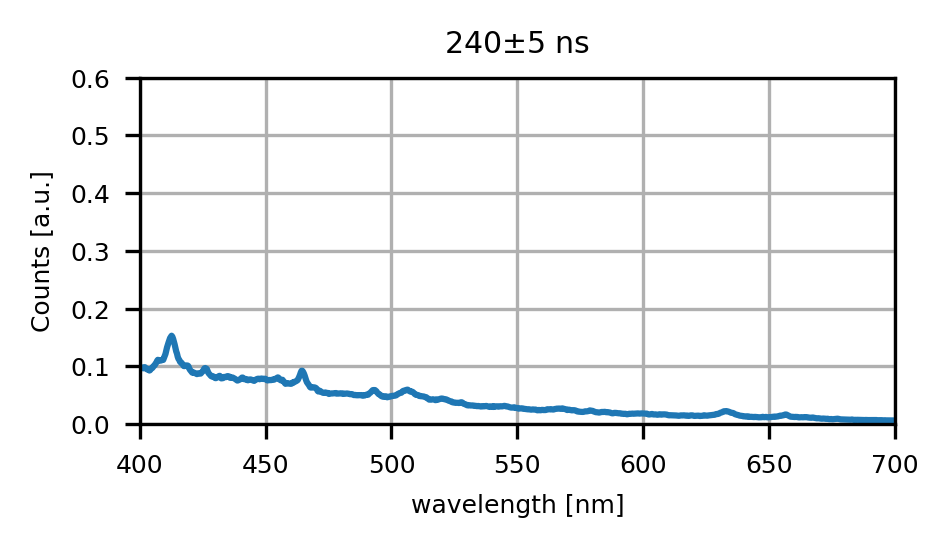

In [6]:
# inDir = "\\Users\\rdatta\\Dropbox (MIT)\\PUFFIN\\Data\\MARZ\\SVS\\z3697\\svs5\\"
inDir = "/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/SVS/z3697/svs4/"

data = np.loadtxt(inDir + '/exp_spectra.csv',delimiter=',') # experimental data
results = pd.read_csv(inDir + 'results.csv', delimiter=',') # CSV with times and results
tid = results.iloc[:,0] # ns
delt = results.iloc[:,1] # ns

num = 1
wl = data[:,0]
Iexp = data[:,num+1]

plt.rcParams.update({'font.size': 6})
fig,axs = plt.subplots(1,1,figsize=(6.5/2,1.5),dpi=300,sharex=True,sharey=True)
axs.plot(wl,Iexp)
axs.set_xlabel('wavelength [nm]')
axs.set_ylim(ymin=0)
axs.set_ylabel('Counts [a.u.]')
axs.grid()
axs.set_xlim([400,700])
axs.set_title(str(tid.iloc[num]) + '$\pm$' + str(delt.iloc[num]) + ' ns')
axs.set_ylim([0,0.6])
plt.show()

<b> (2) Remove extra continuum </b>

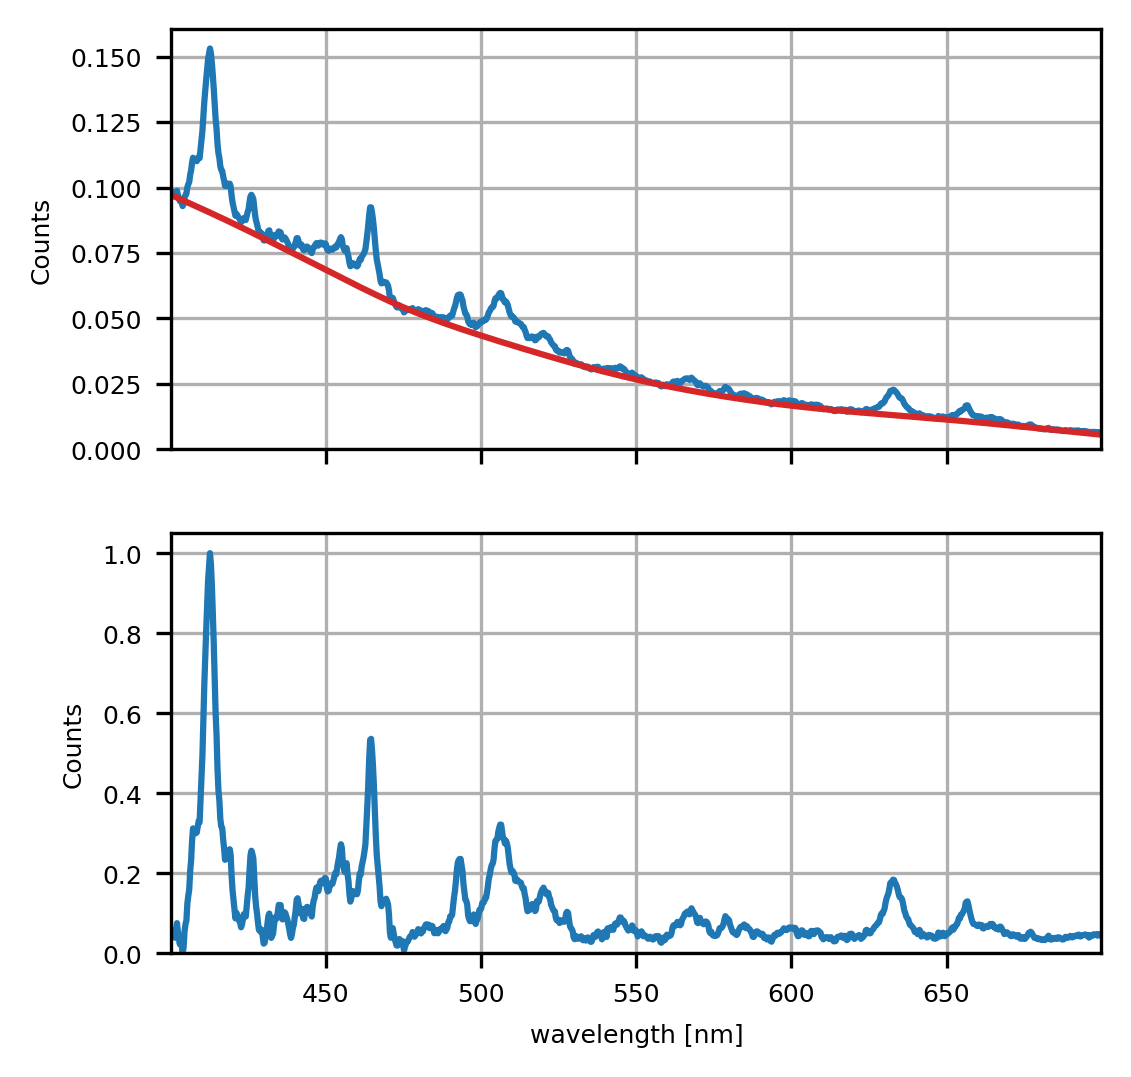

In [7]:
# Isolate so we don't include the absorption feature that complicates the continuum substraction

idx = np.argwhere((wl >= 400) & (wl <=700))
wlnew = np.squeeze(wl[idx])
Inew = np.squeeze(Iexp[idx])

# Continuum fitting

cont =  rt.baseline_als(Inew, 5e5, p=5e-3, niter=50) # find continuum

fig,axs = plt.subplots(2,1,figsize=(4,4),dpi=300,sharex=True)
axs[0].plot(wlnew,Inew)
axs[0].plot(wlnew,cont,color='tab:red')
axs[0].set_ylim(ymin=0)


Inew = Inew - cont
Inew = (Inew - Inew.min()) /  (Inew.max() - Inew.min())

axs[1].plot(wlnew,Inew,color='tab:blue')
axs[1].set_xlabel('wavelength [nm]')

    
for ii in range(axs.shape[0]):
    axs[ii].set_ylim(ymin=0)
    axs[ii].set_ylabel('Counts')
    axs[ii].grid()
    axs[ii].set_xlim([wlnew.min(),wlnew.max()])
    
plt.show()

# save the continuum substacted spectrum
arr = np.vstack([wlnew,Inew]) 
np.save(inDir + 'Exp_spectra/t=' + str(tid.iloc[num]) + '.npy',arr)

In [101]:

print(tid.iloc[num]*1e-9)
getSigma(tid.iloc[num]*1e-9)*1e3

2.4000000000000003e-07


7.0952207166763825

# Optimization

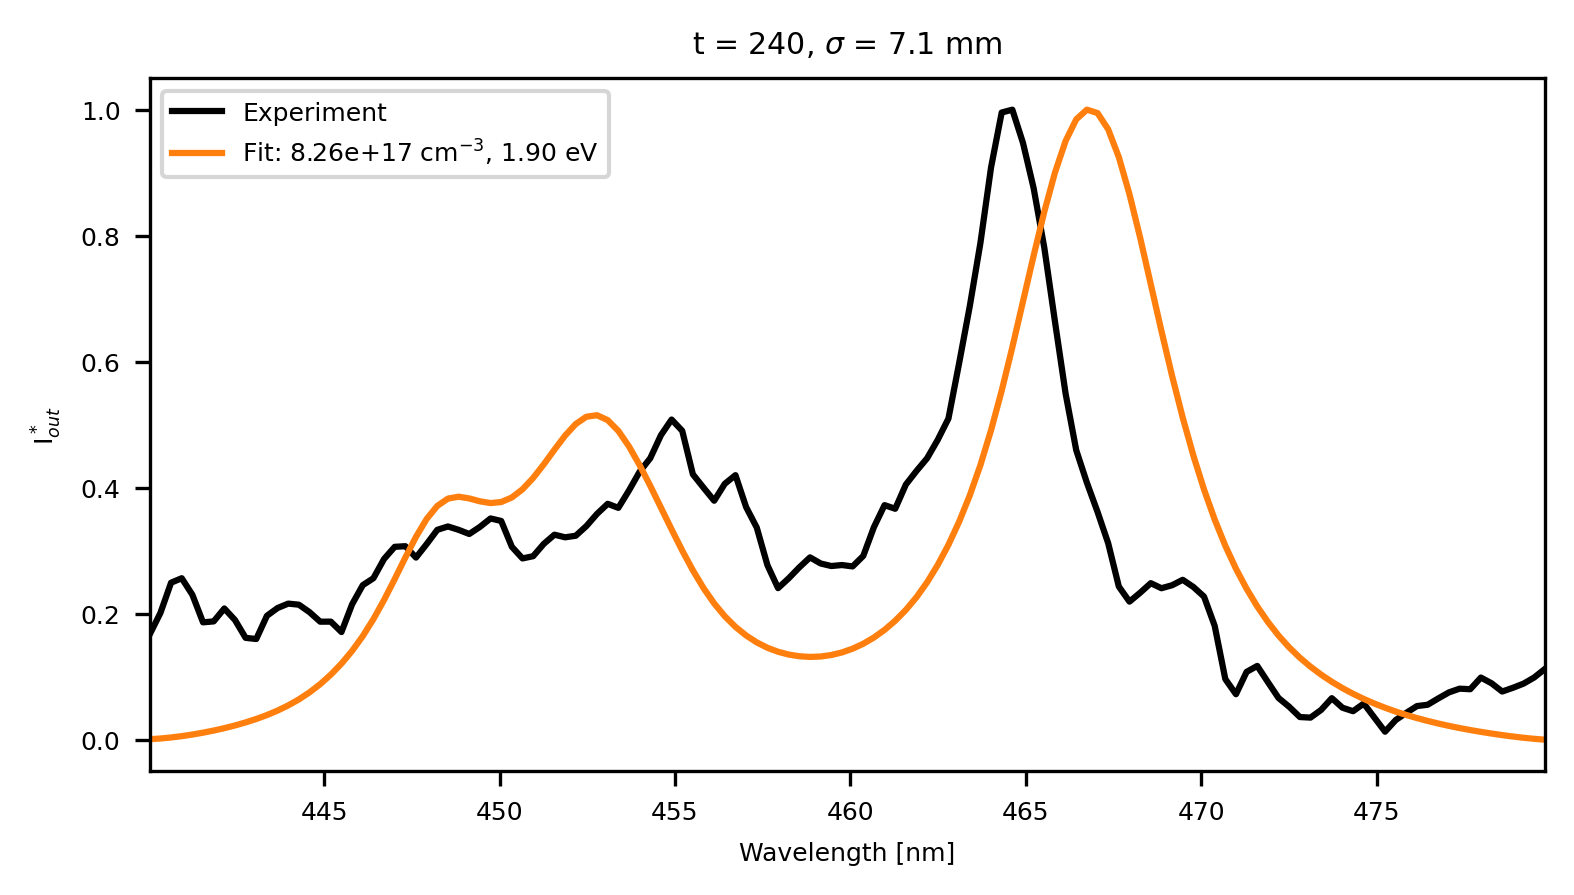

In [102]:
from scipy.optimize import curve_fit

# Interstage lines

E = np.load('./Data/E.npy')

def func(wl,n0,T0):
    sig = getSigma(tid.iloc[num]*1e-9) # m
    smax = 2 * 2.355 * sig # m
    I =  rt.simulate(n0,sig,T0,E,smax,wl,fwhm=1.5)
    return I / I.max()

idx = np.argwhere((wlnew >= 440) & (wlnew <=480)) # fit the ALIII and AlII peaks
x = np.squeeze(wlnew[idx])
y = np.squeeze(Inew[idx])
y = y / y.max()

popt, pcov = curve_fit(func, x, y, bounds=([1e17,1.5], [1e18,3.5]))

# Plot
fig,axs=plt.subplots(1,1,figsize=(6,3),dpi=300)
axs.plot(x,y,label='Experiment',color='k')
axs.plot(x,func(x, *popt),label='Fit: %1.3g cm$^{-3}$, %1.2f eV' % tuple(popt),color='tab:orange')

axs.set_title('t = %1.0d, $\sigma$ = %1.1f mm'%(tid.iloc[num],1e3*getSigma(tid.iloc[num]*1e-9)))

axs.set_xlabel('Wavelength [nm]')
axs.set_ylabel('I$_{out}^*$')
axs.legend()
axs.set_xlim([x.min(),x.max()])
plt.show()

ni_interstage, T_interstage = popt[0], popt[1]


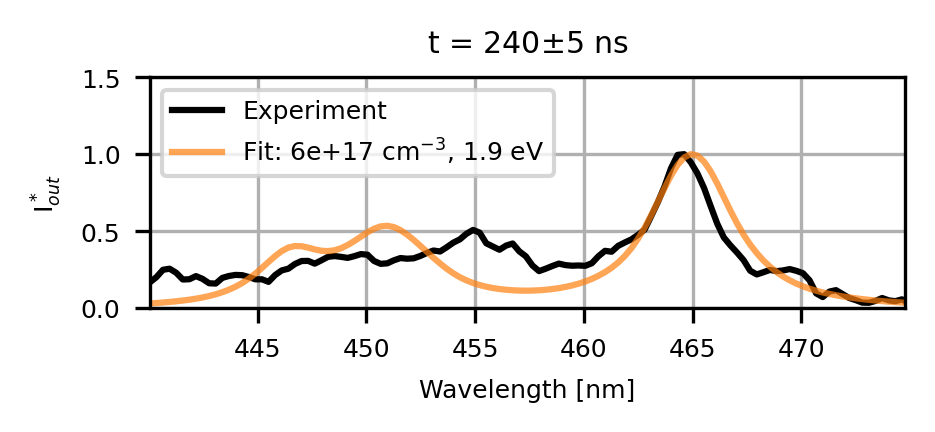

In [103]:
# Plot
fig,axs=plt.subplots(1,1,figsize=(6.5/2,1),dpi=300)
axs.plot(x,y,label='Experiment',color='k')

n0 = 6e17
T0 = 1.9
sig = getSigma(tid.iloc[num]*1e-9)

Iout = rt.simulate(n0,sig,T0,E,2*2.355*sig,wl,fwhm=1.5)
Iout = Iout[idx]
Iout = Iout / Iout.max()
shift = 2
Iout = np.roll(Iout,int(-shift/0.3))
Iout[int(-shift/0.3):] = 0
axs.plot(x,Iout,label='Fit: %1.1g cm$^{-3}$, %1.1f eV' % tuple([n0,T0]),color='tab:orange',alpha=0.7)

axs.set_xlabel('Wavelength [nm]')
axs.set_ylabel('I$_{out}^*$')
axs.set_ylim([0,1.5])
axs.legend()
axs.set_xlim([x.min(),x.max()-5])
axs.grid()
axs.set_title('t = ' + str(tid.iloc[num]) + '$\pm$' + str(delt.iloc[num]) + ' ns')
plt.show()

saveDir = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/SVS/z3697/svs4/'
fname = 'z3697_svs4_' + str(tid.iloc[num])
dic = {}
dic['tid'] = tid.iloc[num]
dic['sig'] = sig
dic['n0'] = n0
dic['T0'] =  T0

import pickle
with open(saveDir + fname + '.pickle', 'wb') as handle:
    pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
fig.savefig(saveDir + fname + '.png',bbox_inches='tight')

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# Fit simulated curve 

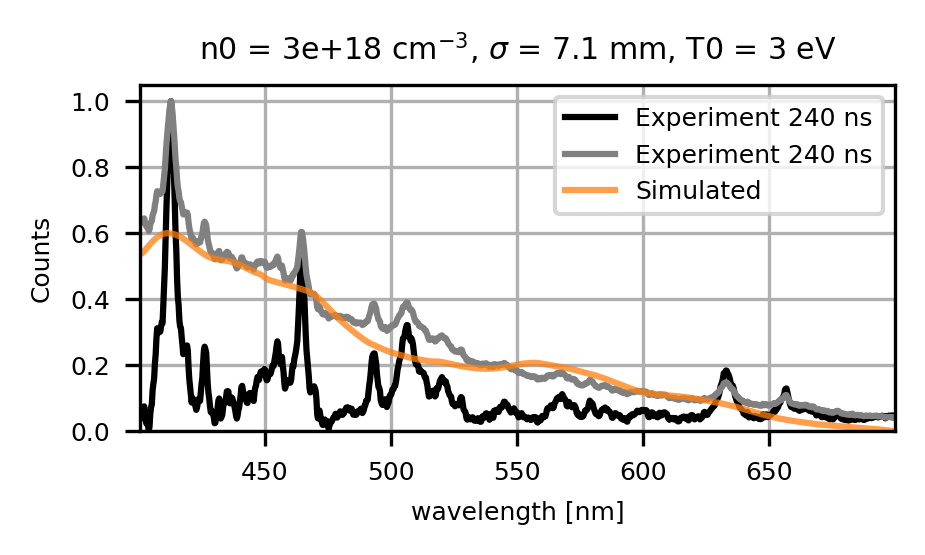

In [34]:
n0 = 3e18
sig = getSigma(tid.iloc[num]*1e-9)
smax = 2 * 2.355 * sig
delT = 0
T0 = 3
E = np.load('./Data/E.npy')

# idx = np.argwhere((wlnew >= 440) & (wlnew <=480))
# x = np.squeeze(wlnew[idx])
# y = np.squeeze(Inew[idx])

Iout = rt.simulate(n0,sig,T0,E,50e-3,wlnew,fwhm=1.625) * 0.6

# Plot
fig,axs=plt.subplots(1,1,figsize=(6.5/2,1.5),dpi=300)
axs.plot(wlnew,Inew,label='Experiment %3.0f ns' % (tid.iloc[num]),color='k')
axs.plot(wl,Iexp/Iexp.max(),label='Experiment %3.0f ns' % (tid.iloc[num]),color='grey')
axs.plot(wlnew,Iout,label='Simulated',color='tab:orange',alpha=0.75)

axs.set_xlabel('Wavelength [nm]')
axs.set_ylabel('I$_{out}^*$')
axs.set_title('n0 = %1.3g cm$^{-3}$, $\sigma$ = %1.2g mm, T0 = %1.3g eV' % (n0,sig*1e3,T0))
axs.legend()
axs.set_xlim([wlnew.min(),wlnew.max()])
axs.set_xlabel('wavelength [nm]')
axs.set_ylim(ymin=0)
axs.set_ylabel('Counts')
axs.grid()
plt.show()

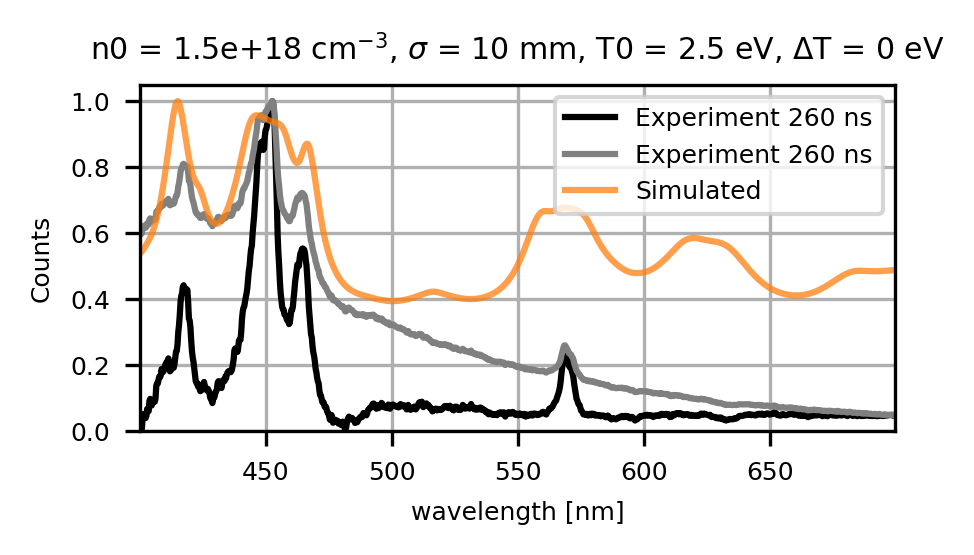

In [115]:
n0 = 1.5e18
sig = 10e-3
smax = 2 * 2.355 * sig
delT = 0
T0 =3
E = np.load('./Data/E.npy')

# idx = np.argwhere((wlnew >= 440) & (wlnew <=480))
# x = np.squeeze(wlnew[idx])
# y = np.squeeze(Inew[idx])

Iout = rt.simulate(n0,sig,T0,E,50e-3,wlnew,fwhm=1.625)

# Plot
fig,axs=plt.subplots(1,1,figsize=(6.5/2,1.5),dpi=300)
axs.plot(wlnew,Inew,label='Experiment %3.0f ns' % (tid.iloc[num]),color='k')
axs.plot(wl,Iexp/Iexp.max(),label='Experiment %3.0f ns' % (tid.iloc[num]),color='grey')
axs.plot(wlnew,Iout/Iout.max(),label='Simulated',color='tab:orange',alpha=0.75)

axs.set_xlabel('Wavelength [nm]')
axs.set_ylabel('I$_{out}^*$')
axs.set_title('n0 = %1.3g cm$^{-3}$, $\sigma$ = %1.2g mm, T0 = %1.3g eV, $\Delta$T = %1.2g eV' % (n0,sig*1e3,T0,delT))
axs.legend()
axs.set_xlim([wlnew.min(),wlnew.max()])
axs.set_xlabel('wavelength [nm]')
axs.set_ylim(ymin=0)
axs.set_ylabel('Counts')
axs.grid()
plt.show()

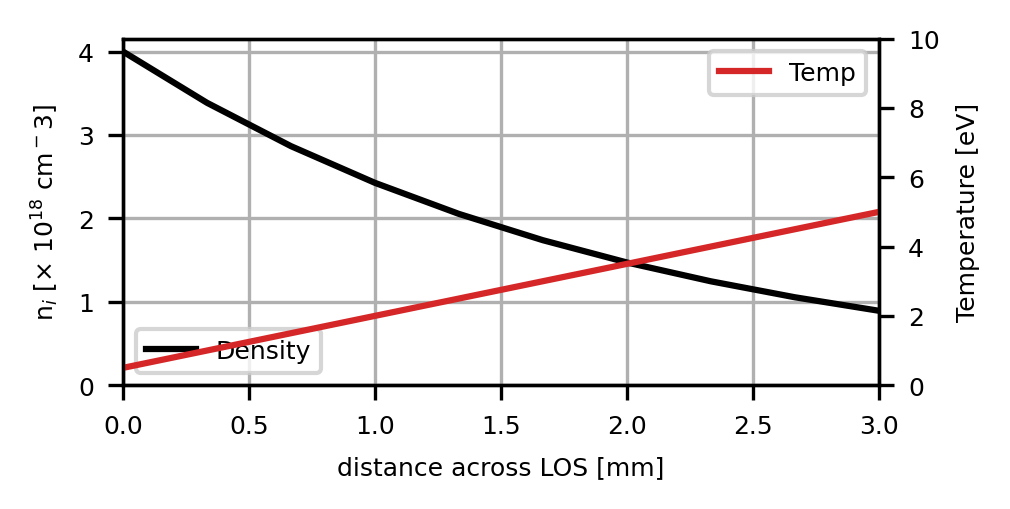

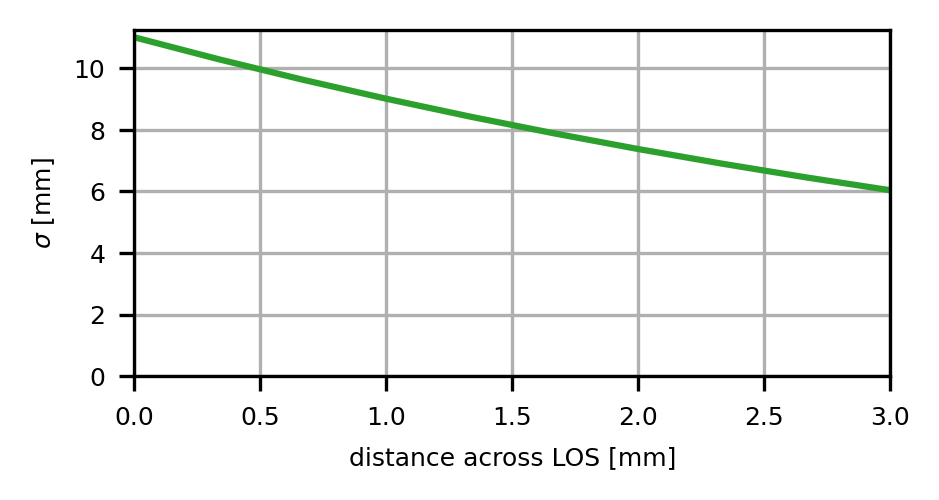

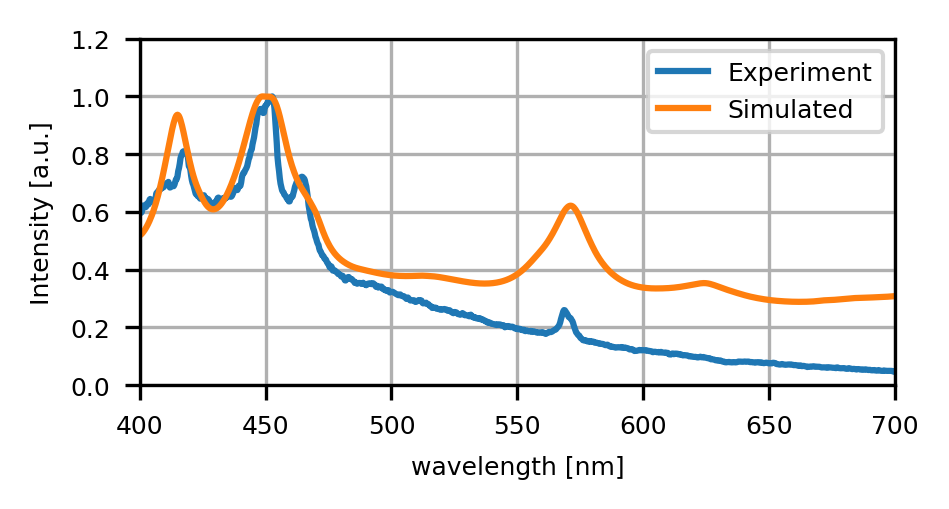

In [119]:
# Allow for variation across LOS

def func(nmax,len_scale,Tmin,Tmax,sig_max,sig_scale,num=10):
    r = np.linspace(0,3e-3,num)
    n = nmax * np.exp(-r/len_scale)
    T = Tmin + (Tmax-Tmin)/3e-3 * r
    sig = sig_max * np.exp(-r/sig_scale)
    return r, n, T, sig

r, n, T, sig = func(4e18,2e-3,0.5,5,sig_max=11e-3,sig_scale=5e-3,num=10)

fig, axs = plt.subplots(1,1,figsize=(6.5/2,3/2),dpi=300)
axs.plot(r*1e3,n/1e18,label='Density',color='k')
axs2 = plt.twinx()
axs2.plot(r*1e3,T,label='Temp',color='tab:red')
axs.grid()
axs.set_xlabel('distance across LOS [mm]')
axs.set_ylabel('n$_i$ [$\\times$ 10$^{18}$ cm$^-3$]')
axs2.set_ylabel('Temperature [eV]')
axs2.set_ylim([0,10])
axs.set_ylim(ymin=0)
axs.set_xlim([0,3])
axs.legend(loc='lower left')
axs2.legend()

fig, axs = plt.subplots(1,1,figsize=(6.5/2,3/2),dpi=300)
axs.plot(r*1e3,sig*1e3,color='tab:green')
axs.grid()
axs.set_xlabel('distance across LOS [mm]')
axs.set_ylabel('$\sigma$ [mm]')
axs.set_ylim(ymin=0)
axs.set_xlim([0,3])

# Show experimental spectra

fig, axs = plt.subplots(1,1,figsize=(6.5/2,3/2),dpi=300)
axs.plot(wl,Iexp/Iexp.max(),label='Experiment')
axs.grid()
axs.set_xlabel('wavelength [nm]')
axs.set_xlim([400,700])
axs.set_ylim([0,1.2])
axs.set_ylabel('Intensity [a.u.]')


# Calculate simulated spectrum
E = np.load('./Data/E.npy')
Iout = rt.simulate_combined(n,T,sig,E=E,wl=wl,fwhm=1.624)

axs.plot(wl,Iout,label='Simulated')

axs.legend()




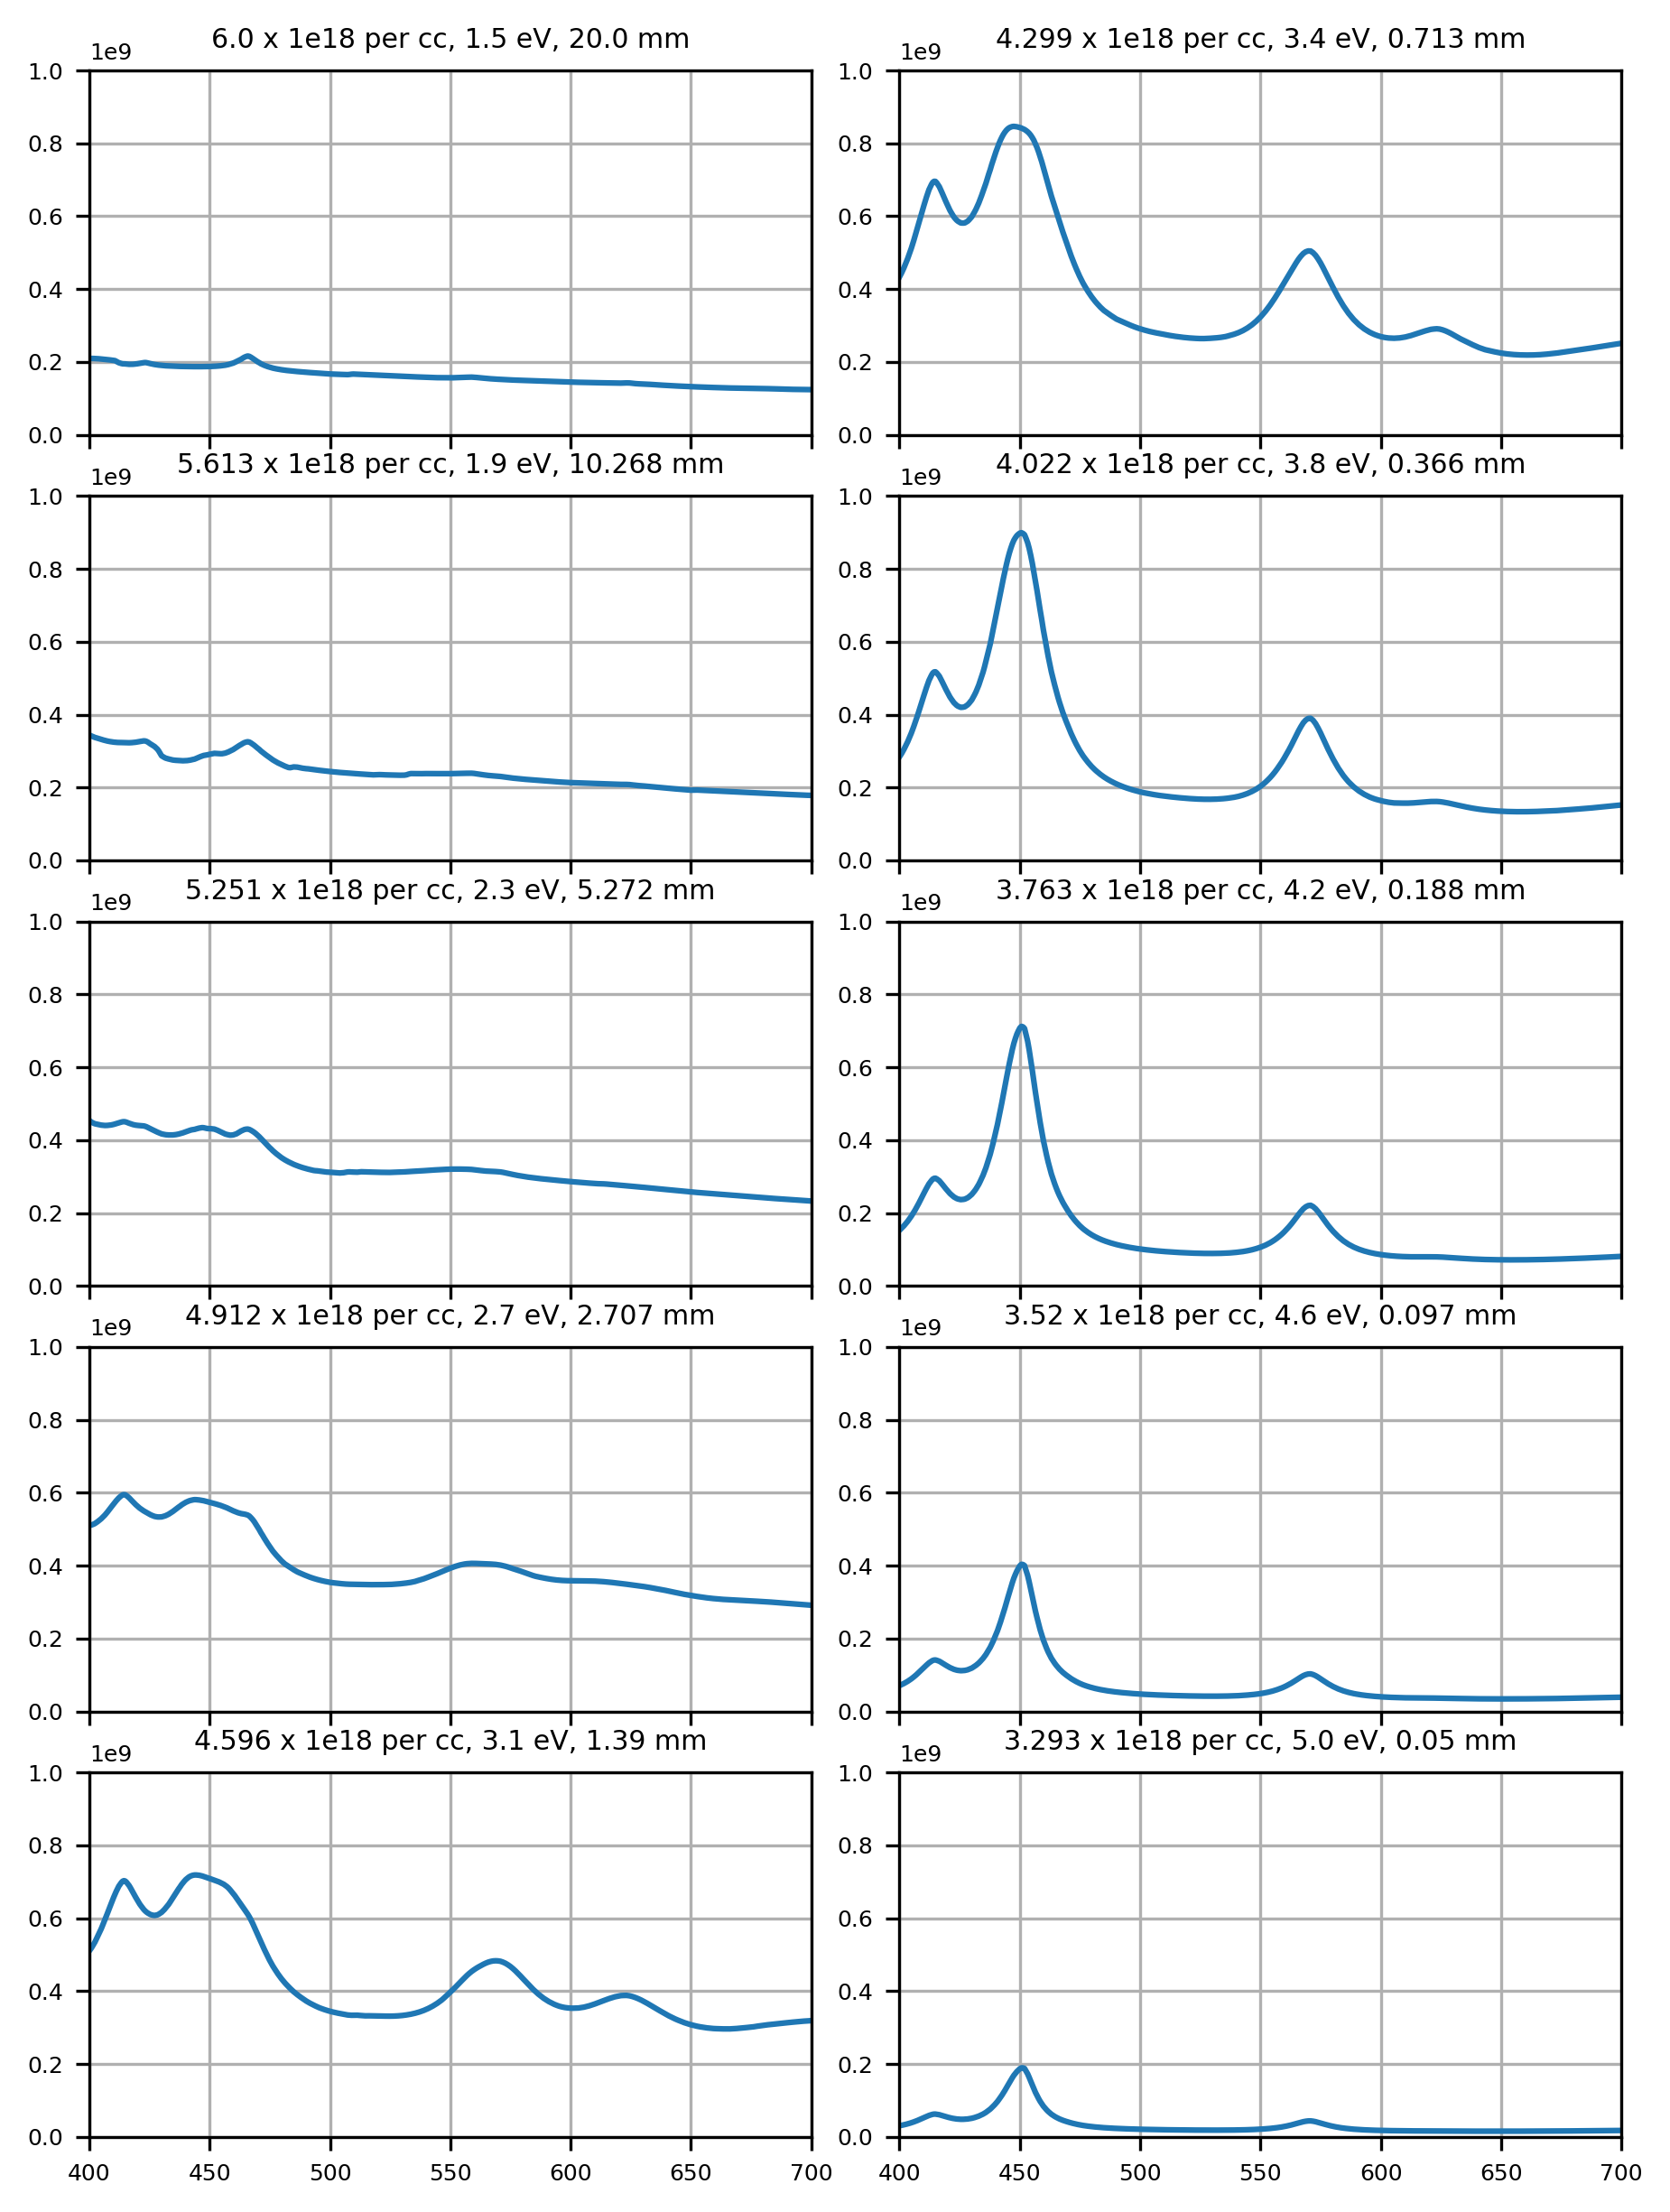

In [90]:
fig, axs = plt.subplots(5,2,figsize=(6,8),dpi=300,sharex=True,sharey=False)
for ii in range(n.shape[0]):
    out = rt.generateSpectrum(n[ii],sig[ii],T[ii],E,smax=2*2.355*sig[ii],normalize=False)
    axs[ii % 5, ii // 5].plot(1239.8/E,out)
    axs[ii % 5, ii // 5].set_title(str(np.round(n[ii]/1e18,3)) + ' x 1e18 per cc, ' + str(np.round(T[ii],1)) +
                                   ' eV, ' + str(np.round(sig[ii]*1e3,3)) + ' mm' )
    axs[ii % 5, ii // 5].set_xlim([400,700])
    axs[ii % 5, ii // 5].set_ylim([0,1e9])
    axs[ii % 5, ii // 5].grid()
plt.tight_layout(pad=0.2)

In [48]:
# Perform optimization

from scipy.optimize import minimize, Bounds
from scipy.optimize import Bounds

def obj_func(x,*args):
    # x = [nmax,len_scale,Tmin,Tmax] vector of variables to optimize
    # *args = [target, sig, wl]
    
    target = args[0]
    sig = args[1]
    wl = args[2]
    
    r, n, T = func(x[0],x[1],x[2],x[3],num=5)
    
    # simulated curve
    E = np.load('./Data/E.npy')
    Iout = rt.simulate_combined(n,T,sig=2*2.55*sig,E=E,wl=wl,fwhm=1.624)
    
    # MSD from target
    msd = 1/Iout.shape[0] * np.sum((Iout - target)**2)
    
    return msd # we minimise the msd from the traget curve

x0 = [1e18,1e-3,2,10]
bounds = Bounds([1e17, 0.2e-3,1,1], [5e18, 4e-3,5,15])
res = minimize(obj_func, x0, bounds=bounds, args=(Iexp/Iexp.max(),10e-3,wl),tol=1e-5,options={'disp': True, maxiter=25})
    

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95488D-02    |proj g|=  3.00000D-03

At iterate    1    f=  1.92143D-02    |proj g|=  2.72681D-03

At iterate    2    f=  1.91429D-02    |proj g|=  2.63257D-03

At iterate    3    f=  1.91260D-02    |proj g|=  2.41952D-03

At iterate    4    f=  1.91240D-02    |proj g|=  2.41045D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4     10      5     0     0   2.410D-03   1.912D-02
  F =   1.9124023803560413E-002

CONVERG

[1.00000000e+18 1.58954811e-03 2.00016826e+00 9.99999217e+00]


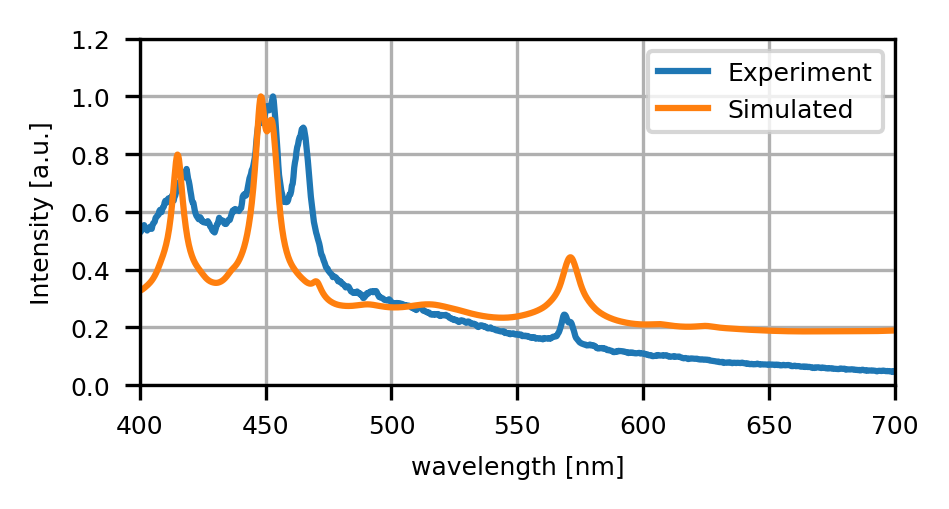

In [49]:
# Show experimental spectra

print(res.x)

r, n, T = func(res.x[0],res.x[1],res.x[2],res.x[3],num=5)

fig, axs = plt.subplots(1,1,figsize=(6.5/2,3/2),dpi=300)
axs.plot(wl,Iexp/Iexp.max(),label='Experiment')
axs.grid()
axs.set_xlabel('wavelength [nm]')
axs.set_xlim([400,700])
axs.set_ylim([0,1.2])
axs.set_ylabel('Intensity [a.u.]')


# Calculate simulated spectrum
E = np.load('./Data/E.npy')
Iout = rt.simulate_combined(n,T,sig=2*2.55*10e-3,E=E,wl=wl,fwhm=1.624)

axs.plot(wl,Iout,label='Simulated')

axs.legend()

Text(0, 0.5, 'n$_i$ [cm$^{-3}$]')

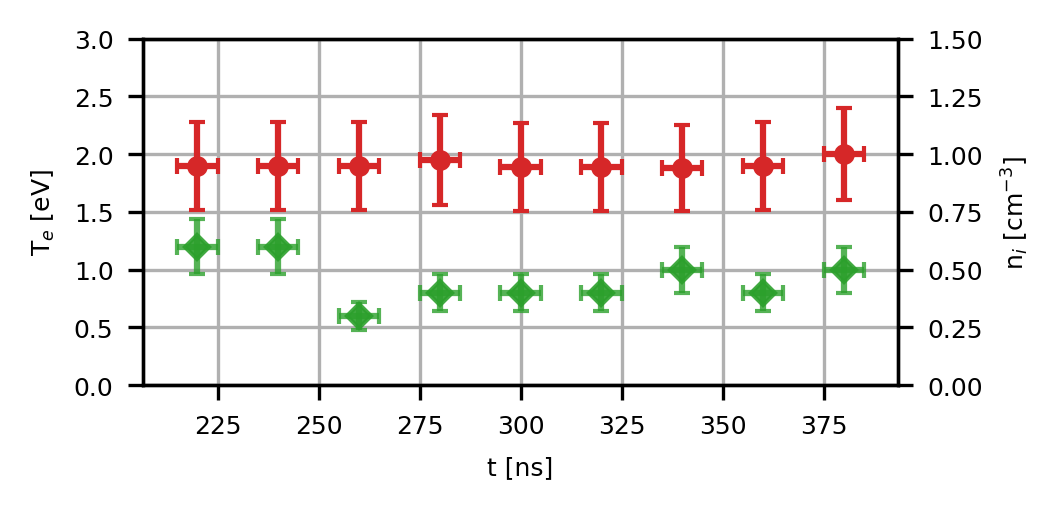

In [104]:
# Show all

inDir = "/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/SVS/z3697/svs4/"

results = pd.read_csv(inDir + 'results.csv', delimiter=',') # CSV with times and results
tid = results.iloc[:,0] # ns
delt = results.iloc[:,1] # ns

saveDir = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Data/MARZ/SVS/z3697/svs4/'

fig, axs = plt.subplots(1,1,figsize=(6.5/2,1.5),dpi=300)
axs2 = axs.twinx()

for ii in range(tid.shape[0]-1):
    
    fname = 'z3697_svs4_' + str(tid.iloc[ii])
    with open(saveDir + fname + '.pickle', 'rb') as handle:
        data = pickle.load(handle)
    
    axs.errorbar(data['tid'],data['T0'], yerr=0.2*data['T0'], xerr=5,capsize=2,color='tab:red')
    axs.plot(data['tid'],data['T0'],marker='o',color='tab:red',markersize=4)
    
    axs2.errorbar(data['tid'],data['n0']/1e18, yerr=0.2*data['n0']/1e18, xerr=5,capsize=2,color='tab:green',alpha=0.8)
    axs2.plot(data['tid'],data['n0']/1e18,marker='D',color='tab:green',alpha=0.9,markersize=4)
    
    
axs.grid()
axs.set_ylim([0,3])

axs2.set_ylim([0,1.5])

axs.set_xlabel('t [ns]')
axs.set_ylabel('T$_e$ [eV]')
axs2.set_ylabel('n$_i$ [cm$^{-3}$]')


